In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.decomposition import PCA

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=933d97a3904765eeb9065b72a3b52ad9a03d5312599dcb5ab9c83e0f6073e654
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# --- Step 1: Load the Data ---
print("--- Step 1: Loading Data ---")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print("Datasets loaded successfully.")
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}\n")

--- Step 1: Loading Data ---
Datasets loaded successfully.
Train data shape: (8693, 14)
Test data shape: (4277, 13)



--- Step 2: Exploratory Data Analysis (EDA) ---
Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

Train DataFrame Description:
       PassengerId HomePlanet CryoSleep   

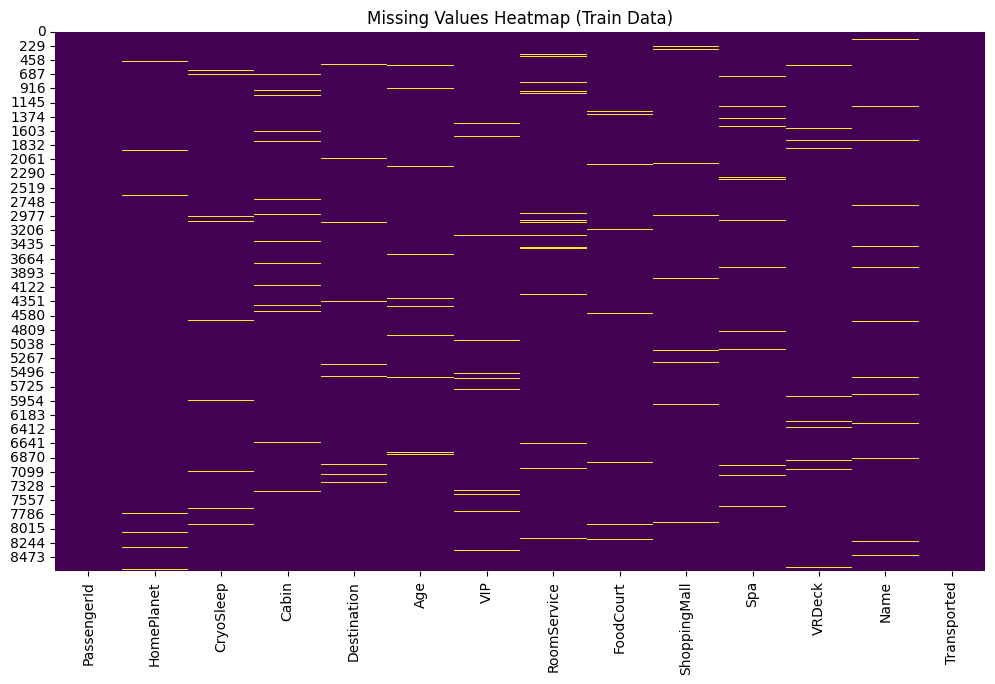

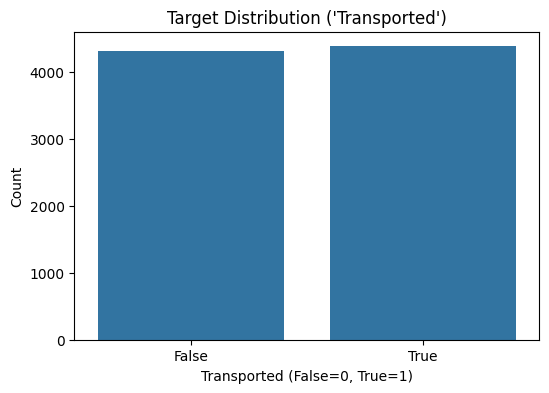

<Figure size 1500x1000 with 0 Axes>

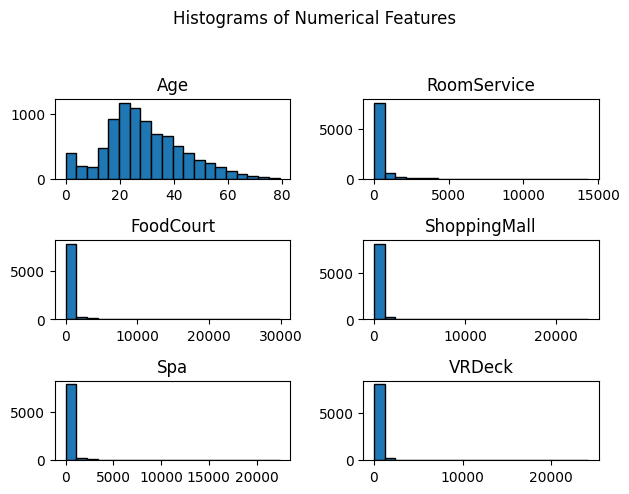

In [ ]:
# --- Step 2: Exploratory Data Analysis (EDA) ---
print("--- Step 2: Exploratory Data Analysis (EDA) ---")

# Basic information and descriptive statistics for training data
print("Train DataFrame Info:")
train_df.info()
print("\nTrain DataFrame Description:")
print(train_df.describe(include='all'))

# Missing values heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap (Train Data)")
plt.show()

# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_df)
plt.title("Target Distribution ('Transported')")
plt.xlabel("Transported (False=0, True=1)")
plt.ylabel("Count")
plt.show()

# Histograms for numerical features
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
plt.figure(figsize=(15, 10))
train_df[numeric_cols].hist(bins=20, edgecolor='black', grid=False)
plt.suptitle("Histograms of Numerical Features", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()

In [ ]:
# --- Step 3: Preprocessing ---
print("--- Step 3: Preprocessing ---")

# Separate target variable before imputation and encoding
train_labels = train_df['Transported'].astype(int)
train_df_processed = train_df.drop(['Transported'], axis=1)

# Combine train and test for consistent preprocessing
combined_df = pd.concat([train_df_processed, test_df], ignore_index=True)

# Identify numerical and categorical features
num_features_combined = combined_df.select_dtypes(include=['float64', 'int64']).columns
cat_features_combined = combined_df.select_dtypes(include='object').columns

# Impute missing numerical values with the median
for col in num_features_combined:
    median_val = combined_df[col].median()
    combined_df[col] = combined_df[col].fillna(median_val)
    print(f"Filled missing numerical values in '{col}' with median: {median_val}")

# Impute missing categorical values with 'Unknown'
for col in cat_features_combined:
    combined_df[col] = combined_df[col].fillna('Unknown')
    print(f"Filled missing categorical values in '{col}' with 'Unknown'")

# Drop irrelevant features (PassengerId, Name, Cabin)
# PassengerId is needed for submission, so we'll store it from the original test_df
passenger_ids = test_df['PassengerId']
combined_df = combined_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1)
print("Dropped 'PassengerId', 'Name', 'Cabin' columns.")

# One-hot encode categorical features
print("Performing one-hot encoding on categorical features...")
combined_encoded = pd.get_dummies(combined_df, drop_first=True)
print(f"Shape after one-hot encoding: {combined_encoded.shape}\n")

# Split back into training and testing sets
X_train_pre_pca = combined_encoded.iloc[:len(train_labels), :]
X_test_pre_pca = combined_encoded.iloc[len(train_labels):, :]
y_train = train_labels



print(f"Cumulative explained variance by {n_components_pca} components: {pca.explained_variance_ratio_.sum():.4f}\n")


--- Step 3: Preprocessing ---
Filled missing numerical values in 'Age' with median: 27.0
Filled missing numerical values in 'RoomService' with median: 0.0
Filled missing numerical values in 'FoodCourt' with median: 0.0
Filled missing numerical values in 'ShoppingMall' with median: 0.0
Filled missing numerical values in 'Spa' with median: 0.0
Filled missing numerical values in 'VRDeck' with median: 0.0
Filled missing categorical values in 'PassengerId' with 'Unknown'
Filled missing categorical values in 'HomePlanet' with 'Unknown'
Filled missing categorical values in 'CryoSleep' with 'Unknown'
Filled missing categorical values in 'Cabin' with 'Unknown'
Filled missing categorical values in 'Destination' with 'Unknown'
Filled missing categorical values in 'VIP' with 'Unknown'
Filled missing categorical values in 'Name' with 'Unknown'
Dropped 'PassengerId', 'Name', 'Cabin' columns.
Performing one-hot encoding on categorical features...
Shape after one-hot encoding: (12970, 16)

Cumulative 